# Module 5 : Exemples d'apprentissage profond

IMPORTANT: Copie du notebook!

Vous devez faire une copie du notebook dans votre drive avant de l'exécuter, car les modifications dans le notebook original ne seront pas sauvegardées. Vous travaillerez ainsi dans la copie et non dans l'original.

Importation des fichiers à utiliser dans le tutoriel.

In [ ]:
%%bash
git clone https://github.com/Cours-EDUlib/IVADO-AA.git
mv IVADO-AA/module_5/ressources/* ./
rm -r IVADO-AA

In [ ]:
# Installation des dépendances
!pip install -r requirements.txt

In [ ]:
# Import des bibliothèques utilisées tout au long du tutoriel
from matplotlib import pyplot as plt
from matplotlib import colors


from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron

import numpy as np

import torch
import torch.nn as nn
from torch.optim import SGD, Adam

from poutyne.utils import set_seeds
from poutyne import Accuracy

from torchvision.datasets import FashionMNIST
from torchvision.transforms import PILToTensor
from torch.utils.data import random_split
from PIL import Image

from utils import frontieres_de_decision, entrainer_reseau

In [ ]:
# Paramètres d'affichage des figures avec Matplotlib
figure = {"dpi": 200, "figsize": [6, 4]}

font = {'weight': 'bold', 'size': 20}

plt.rc('figure', **figure)
plt.rc('font', **font)

## Neurone artificiel

Les neurones artificiels sont inspirés des neurones biologiques et constituent la base de l'apprentissage profond.

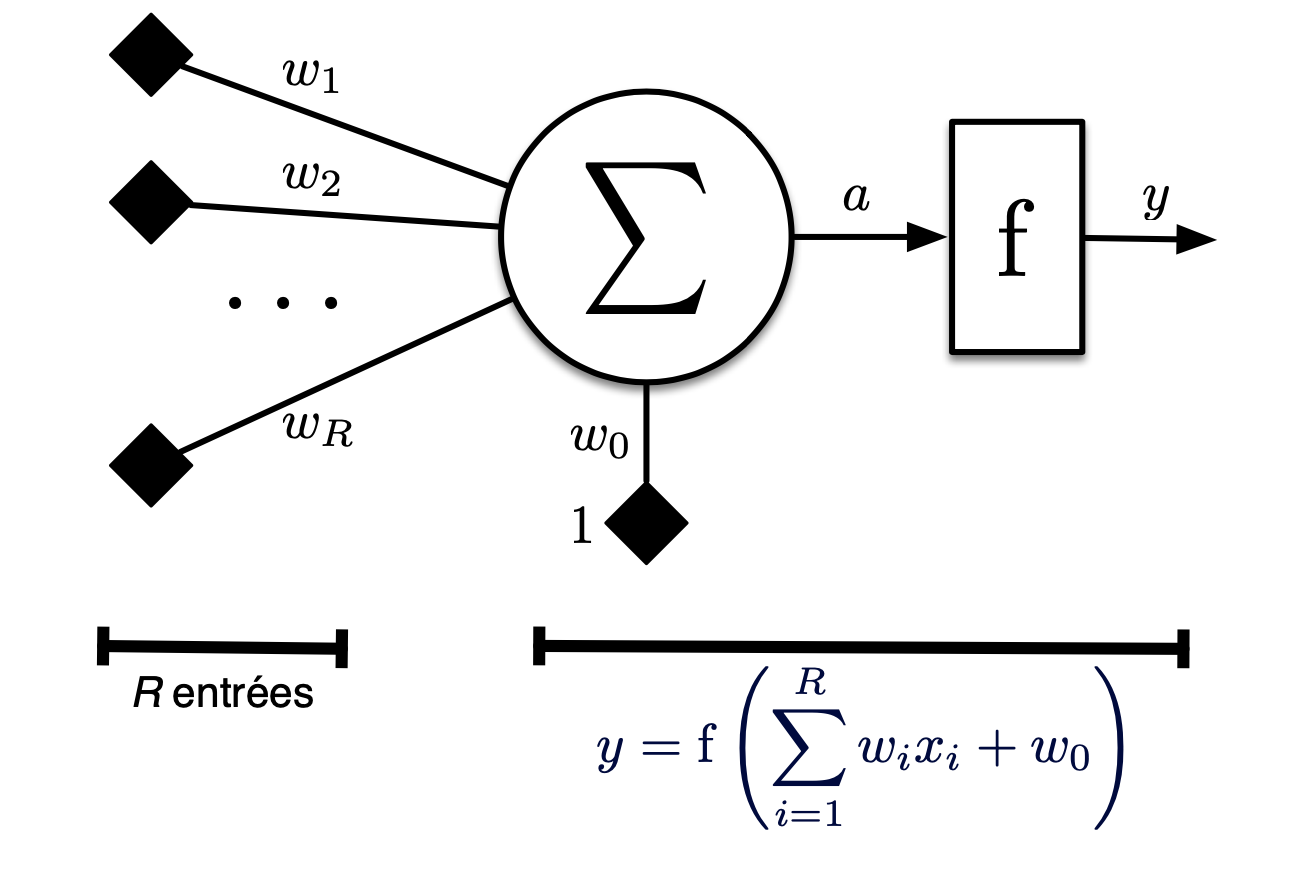



Nous allons utiliser un neurone artificiel pour effectuer la classification binaire du jeu de données suivant:

In [ ]:
X, y = make_blobs(n_samples=250, n_features=2, centers=2, random_state=42)

fig = plt.figure()

plt.scatter(X[y == 0, 0], X[y == 0, 1], c="red", label="Classe 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Classe 1")

plt.legend(loc="upper right")

plt.show()

Divisons le jeu de données en un ensemble d'entrainement et un ensemble de test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

Nous allons utiliser la classe [Perceptron de Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) pour créer notre neurone artificiel.

Cette classe permet de créer un perceptron, c'est-à-dire un neurone artificiel sans fonction d'activation (ou encore, dont la fonction d'activation est la fonction identité).

**Question:** choisissez un nombre d'itérations d'entrainement afin d'obtenir une exactitude de 100%. Vous pouvez expérimenter avec différents nombres d'itérations.

In [ ]:
# Remplacez la point d'intérrogation avec votre réponse à la question précédente
nombre_d_iterations = 100

neurone_artificiel = Perceptron(random_state=42, max_iter=nombre_d_iterations)

Effectuons l'entrainement du neurone artificiel sur l'ensemble d'entrainement.

In [ ]:
neurone_artificiel.fit(X_train, y_train)

Ensuite, évaluons l'exactitude du modèle entrainé sur l'ensemble de test.

In [ ]:
exactitude = neurone_artificiel.score(X_test, y_test)

print(f"Exactitude du neurone sur l'ensemble de test: {exactitude*100}%")

Affichons la frontière de décision du neurone.

In [ ]:
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.02

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = neurone_artificiel.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu, shading='auto')

plt.scatter(X[y == 0, 0], X[y == 0, 1], c="red", label="Classe 0", edgecolors="k")
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Classe 1", edgecolors="k")

plt.title("Frontière de décision du neurone artificiel")

plt.legend(loc="upper right")

plt.show()

Le neurone a ainsi réussi à classifier les données parfaitement.

## Perceptron multicouche

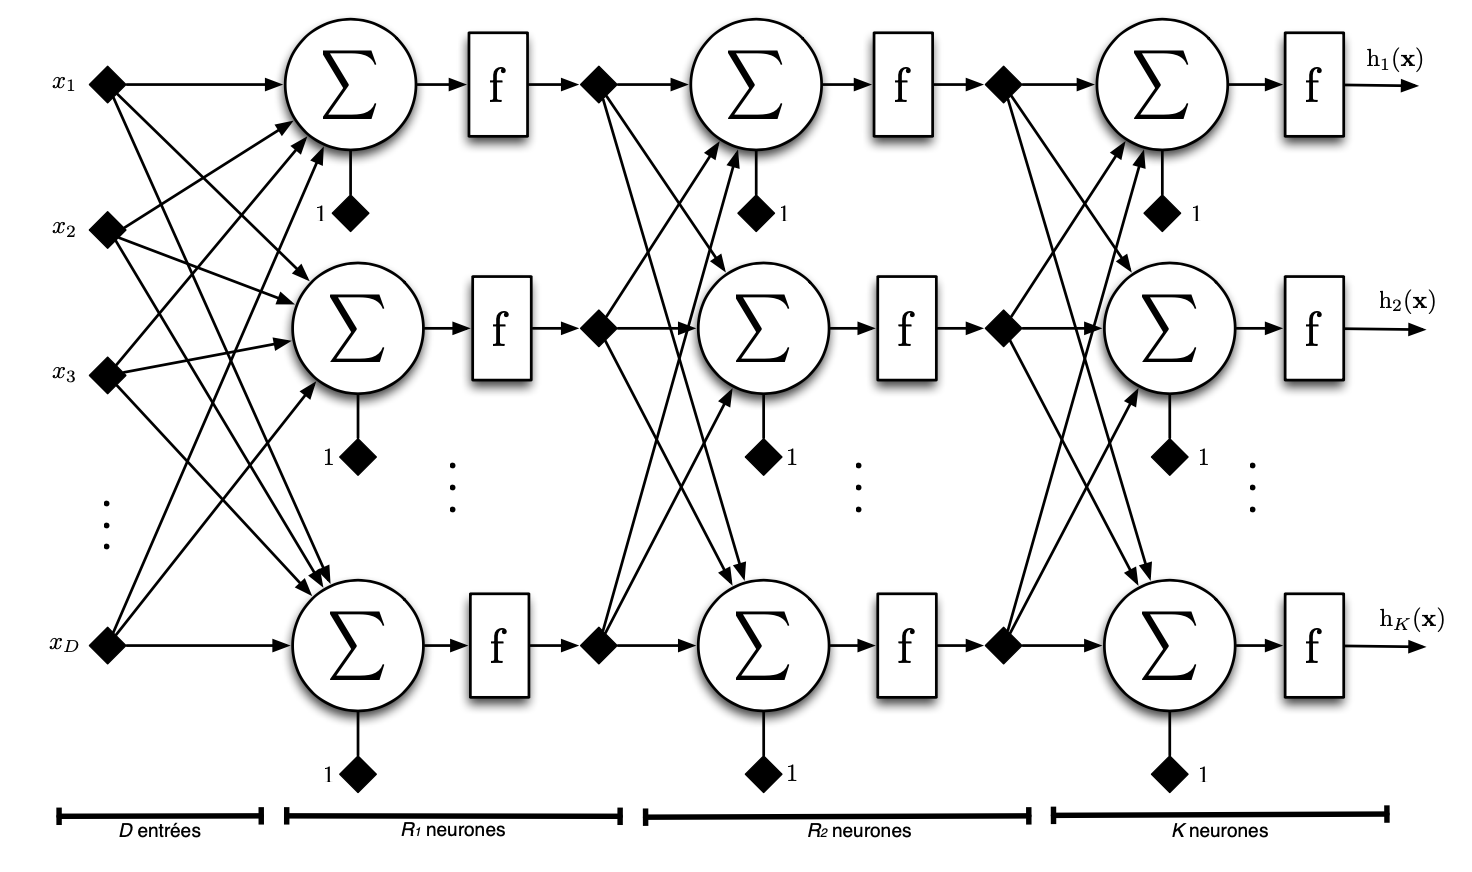

### Classification linéaire

Nous allons utiliser un perceptron multicouche pour classifier le jeu de données présenté ci-haut.

Cette fois-ci, nous allons effectuer l'implémentation en utilisant la bibliothèque [PyTorch](https://pytorch.org).

La classe [`Sequential()`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) permet de créer une séquence de couches alors que la classe [`
Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) permet de créer une couche pleinement connectée. Nous allons utiliser ces deux classes pour définir un perceptron multicouche composé d'une séquence de couches pleinement connectées.

La dernière couche est dotée d'une fonction d'activation **Softmax**.

In [ ]:
set_seeds(42)

perceptron_multicouche = nn.Sequential(nn.Linear(2, 50),
									nn.Linear(50, 50),
									nn.Linear(50, 50),
									nn.Linear(50, 1),
									nn.Sigmoid())

L'algorithme d'apprentissage et la fonction de perte sont définis dans la cellule suivante.

**Question**: La classe `SGD` perrmet de définir l'algorithme d'apprentissage par descente du gradient. Le deuxième argument représente le taux d'apprentissage. **Choisissez un taux d'apprentissage afin d'avoir une exactitude de 100% après l'entrainement du perceptron multicouche**.

*Astuce*: expérimentez avec différents taux d'apprentissage entre 0.01 et 10.

In [ ]:
# Remplacez la point d'intérrogation avec votre réponse à la question précédente
taux_d_apprentissage = 0.1

# Définition de l'algorithme de rétropropagation du gradient
optimiseur = SGD(perceptron_multicouche.parameters(), taux_d_apprentissage)

# Définition de la fonction de perte
fct_perte = nn.BCELoss()

Entrainons le perceptron multicouche pendant 10 cycles.

In [ ]:
# 10 cycles d'entrainement
for i in range(10):
    # L'apprentissage est fait en ligne
    for j in range(X_train.shape[0]):
        # Nous mettons les gradients des paramètres à 0 au début de chaque cycle
        optimiseur.zero_grad()

        # Calcul des sorties du réseau
        predictions = perceptron_multicouche(torch.Tensor(X_train[j, :]))

        # Calcul de la perte
        perte = fct_perte(predictions, torch.Tensor([y_train[j]]))

        # Rétropropagation du gradient
        perte.backward()

        # Mise à jour des paramètres du réseau
        optimiseur.step()

Évaluons l'exactitude du perceptron multicouche sur les données de test.

In [ ]:
# Calcul des prédictions
pred = perceptron_multicouche(torch.Tensor(X_test))
pred = (pred > 0.5).float().squeeze()

verite = torch.Tensor(y_test)

# Calcul de l'exactitude
exactitude = (verite == pred).float().sum() / y_test.shape[0]

print(f"Exactitude sur l'ensemble de test: {exactitude * 100}%")

**N.B:** pour le reste du tutoriel, nous allons utiliser la fonction `frontieres_de_decision` contenue dans *utils.py* pour représenter les frontières de décision des modèles appris.

In [ ]:
frontieres_de_decision(X, y, perceptron_multicouche, ["red", "blue"], plt.cm.RdBu, "Frontière de décision du perceptron multicouche")

Tout comme un neurone unique, le perceptron multicouche a réussi à séparer les deux classes parfaitement.

Augmentons le nombre de classes à quatre dans le jeu de données.

In [ ]:
X, y = make_blobs(n_samples=250, n_features=2, centers=4, random_state=42)

fig = plt.figure()

plt.scatter(X[y == 0, 0], X[y == 0, 1], c="red", label="Classe 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Classe 1")
plt.scatter(X[y == 2, 0], X[y == 2, 1], c="green", label="Classe 2")
plt.scatter(X[y == 3, 0], X[y == 3, 1], c="orange", label="Classe 3")

plt.legend(loc="upper right")

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

Nous allons essayer d'effectuer la classification de ces données avec un réseau similaire au précédent.

**Question**: selon vous, combien de neurones devrait contenir la couche de sortie du nouveau réseau pour permettre de gérer nos quatre classes?

In [ ]:
set_seeds(42)

# Remplacez la point d'intérrogation avec votre réponse à la question précédente
nombre_de_neurones_en_sortie = 4

perceptron_multicouche = nn.Sequential(nn.Linear(2, 50),
									nn.Linear(50, 50),
									nn.Linear(50, 50),
									nn.Linear(50, nombre_de_neurones_en_sortie),
									nn.Softmax(dim=1))

In [ ]:
# Définition de l'algorithme de rétropropagation du gradient
optimiseur = SGD(perceptron_multicouche.parameters(), 0.01)

# Définition de la fonction de perte
fct_perte = nn.NLLLoss()

In [ ]:
# 100 cycles d'entrainement
for i in range(100):
    # L'apprentissage est fait en ligne
    for j in range(X_train.shape[0]):
        # Nous mettons les gradients des paramètres à 0 au début de chaque cycle
        optimiseur.zero_grad()

        # Calcul des sorties du réseau
        predictions = perceptron_multicouche(torch.Tensor(X_train[j, :]).unsqueeze(0))

        # Calcul de la perte
        perte = fct_perte(predictions, torch.Tensor([y_train[j]]).type(torch.LongTensor))

        # Rétropropagation du gradient
        perte.backward()

        # Mise à jour des paramètres du réseau
        optimiseur.step()

In [ ]:
pred = perceptron_multicouche(torch.Tensor(X_test))
pred = torch.argmax(pred, dim=1)

verite = torch.Tensor(y_test)

exactitude = (verite == pred).float().sum() / y_test.shape[0]

print(f"Exactitude sur l'ensemble de test: {exactitude * 100}%")

In [ ]:
frontieres_de_decision(X, y, perceptron_multicouche, ["red", "blue", "green", "orange"], colors.ListedColormap(["#d10000", "#0000c7", "g", "#FFA500"]), "Frontières de décision du perceptron multicouche")

### Données linéairement non-séparables

Nous allons maintenant essayer de classifier des données linéairement non-séparables.

In [ ]:
X, y = make_circles(500, random_state=42, noise=0.09, factor=0.2)

fig = plt.figure()

plt.scatter(X[y == 0, 0], X[y == 0, 1], c="red", label="Classe 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Classe 1")

plt.legend(loc="upper right")

plt.show()

Nous allons séparer le jeu de données en trois ensembles: un ensemble d'entrainement, un ensemble de validation et un ensemble de test.

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42
)


X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

Essayons de classifier ce jeu de données avec un perceptron multicouche similaire aux précédents.

In [ ]:
set_seeds(42)

perceptron_multicouche = nn.Sequential(nn.Linear(2, 50),
									nn.Linear(50, 50),
									nn.Linear(50, 50),
									nn.Linear(50, 1),
									nn.Sigmoid())

In [ ]:
optimiseur = SGD(perceptron_multicouche.parameters(), 0.1)

fct_perte = nn.BCELoss()

In [ ]:
for i in range(20):
    for j in range(X_train.shape[0]):
        # Mise à 0 des gradients
        optimiseur.zero_grad()

        # Calcul des sorties du réseau
        predictions = perceptron_multicouche(torch.Tensor(X_train[j, :]))

        # Calcul de la perte
        perte = fct_perte(predictions, torch.Tensor([y_train[j]]))

        # Rétropropagation du gradient
        perte.backward()

        # Mise à jour des paramètres du réseau
        optimiseur.step()

In [ ]:
pred = perceptron_multicouche(torch.Tensor(X_test))

pred = (pred > 0.5).float().squeeze()
verite = torch.Tensor(y_test)

exactitude = (verite == pred).float().sum() / y_test.shape[0]

print(f"Exactitude sur l'ensemble de test: {exactitude * 100}%")

In [ ]:
frontieres_de_decision(X, y, perceptron_multicouche, ["red", "blue"], colors.ListedColormap(["#d10000", "#0000c7"]), "Frontière de décision du perceptron multicouche")

Ainsi, le réseau n'a pas réussi à apprendre une bonne classification des données.

Nous allons essayer de classifier les mêmes données avec un réseau dont les couches cachées sont dotées d'une fonction d'activation **ReLU**.

In [ ]:
class ReseauNonLineaire(nn.Module):
	def __init__(self, device):
		super().__init__()

		self.device = device
		
		self.couche_entree = nn.Linear(2, 4)

		self.couche_cachee = nn.Linear(4, 4)

		self.couche_sortie = nn.Linear(4, 2)

		self.activation = nn.ReLU()

		self.softmax = nn.Softmax(dim=1)

	def forward(self, entree):
		entree = self.activation(self.couche_entree(entree.type(torch.FloatTensor).to(self.device)))
		entree = self.activation(self.couche_cachee(entree))

		sortie = self.softmax(self.couche_sortie(entree))

		return sortie

Pour le reste du tutoriel, nous allons utiliser la fonction `entrainer_reseau` contenue dans *utils.py* pour l'entrainement des réseaux de neurones artificiels. Cette fonction permet d'effectuer un apprentissage par mini-lots (*mini-batch*).

In [ ]:
set_seeds(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

reseau = ReseauNonLineaire(device)
reseau.to(device)

optimiseur = SGD(reseau.parameters(), 0.1)


entrainer_reseau(reseau, (X_train,
    y_train),
    (X_valid,
    y_valid),
    cycles=30,
    mini_batch_taille=8,
    fct_perte=nn.NLLLoss(),
    optimiseur=optimiseur,
    device=device)

In [ ]:
frontieres_de_decision(X, y, reseau, ["red", "blue"], plt.cm.RdBu, "Frontière de décision du réseau non linéaire")

Donc, en ajoutant une non-linéarité sous forme d'une fonction d'activation **ReLU**, le réseau a réussi à gérer des données linéairement non-séparables.

## Application pratique: classification d'images

Nous allons effectuer un dernier exemple de classification d'images en utilisant deux réseaux de neurones artificiels: un **perceptron multicouche** (MLP) et un **réseau de neurones à convolution** (CNN).

Commençons par charger les données. Nous allons utiliser le jeu de données
[FashionMNIST](https://github.com/zalandoresearch/fashion-mnist).

In [ ]:
train_dataset = FashionMNIST("./assets/data/", download=True, transform=PILToTensor())

train_dataset, val_dataset = random_split(
    train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(42)
)

In [ ]:
test_dataset = FashionMNIST("./assets/data/", download=True, train=False, transform=PILToTensor())
test_samples, test_ground_truth = zip(*[i for i in test_dataset])

test_samples = torch.stack(test_samples)
test_ground_truth = torch.Tensor(test_ground_truth)

Visualisons les données.

In [ ]:
fig, axes = plt.subplots(2, 2)

for row in axes:
	for column in row:
		column.imshow(train_dataset[np.random.randint(0, len(train_dataset))][0].squeeze().numpy(), cmap='gray', vmin=0, vmax=255)

## Classification avec MLP

In [ ]:
class MLP(nn.Module):
	def __init__(self, device) -> None:
		super().__init__()

		self.device = device

		self.mlp = nn.Sequential(nn.Flatten(),
					nn.Linear(28*28, 28*28),
					nn.ReLU(),
					nn.Linear(28*28, 28*28),
					nn.ReLU(),
					nn.Linear(28*28, 10))

	def forward(self, entree):
		return self.mlp(entree.type(torch.FloatTensor).to(self.device))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp = MLP(device)
mlp.to(device)

optimiseur = SGD(mlp.parameters(), lr=0.001)

fct_perte = nn.CrossEntropyLoss()

In [ ]:
entrainer_reseau(mlp, train_dataset, val_dataset, 10, fct_perte, optimiseur, device, 64)

In [ ]:
exactitude = Accuracy()

In [ ]:
pred = mlp(test_samples)

In [ ]:
print(f"Exactitude du MLP sur l'ensemble de test: {round(exactitude(pred, test_ground_truth.to(device)).item(), 2)}%")

## Classification avec CNN

In [ ]:
class CNN(nn.Module):
	def __init__(self, device) -> None:
		super().__init__()

		self.device = device

		self.cnn = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
								nn.ReLU(),
								nn.MaxPool2d(2),
								nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
								nn.ReLU(),
								nn.MaxPool2d(2),
								nn.Flatten(),
								nn.Dropout(),
								nn.Linear(16*7*7, 128),
								nn.ReLU(),
								nn.Linear(128, 10))

	def forward(self, entree):
		return self.cnn(entree.type(torch.FloatTensor).to(device))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = CNN(device)
cnn.to(device)

optimiseur = Adam(cnn.parameters(), lr=0.001)

fct_perte = nn.CrossEntropyLoss()

In [ ]:
entrainer_reseau(cnn, train_dataset, val_dataset, 5, fct_perte, optimiseur, device, 64)

In [ ]:
pred = cnn(test_samples)

In [ ]:
print(f"Exactitude du CNN sur l'ensemble de test: {round(exactitude(pred, test_ground_truth.to(device)).item(), 2)}%")

Ainsi, l'utilisation d'un CNN a permis une augmentation de l'exactitude.